In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
xle_raw = pd.read_csv('XLE.csv', delimiter=";", parse_dates=["datetime"]).set_index("datetime")
xlu_raw = pd.read_csv('XLU.csv', delimiter=";", parse_dates=["datetime"]).set_index("datetime")

In [58]:
rth_raw = pd.read_csv('RTH.csv', delimiter=";", parse_dates=["datetime"]).set_index("datetime")
xlp_raw = pd.read_csv('XLP.csv', delimiter=";", parse_dates=["datetime"]).set_index("datetime")

In [2]:
iye_raw = pd.read_csv('IYE.csv', delimiter=";", parse_dates=["datetime"]).set_index("datetime")
vde_raw = pd.read_csv('VDE.csv', delimiter=";", parse_dates=["datetime"]).set_index("datetime")

In [3]:
iye_raw

,open,high,low,close,volume
datetime,,,,,
2023-09-18,48.63,48.84,48.30,48.74,80354
2023-09-15,48.60,48.96,48.27,48.30,424600
2023-09-14,48.84,49.10,48.76,48.97,292500
2023-09-13,48.84,48.92,48.11,48.34,447200
2023-09-12,48.07,48.83,48.07,48.76,329900
...,...,...,...,...,...
2010-01-08,34.67,35.03,34.57,35.03,200800
2010-01-07,34.75,34.86,34.49,34.75,216100
2010-01-06,34.45,34.96,34.36,34.89,366600


In [4]:
vde_raw

,open,high,low,close,volume
datetime,,,,,
2023-09-18,129.94,130.35001,128.87000,130.17,132631
2023-09-15,129.75,130.64999,128.75999,128.89,464700
2023-09-14,130.30,131.07001,130.08000,130.52,544500
2023-09-13,130.27,130.50999,128.36000,129.00,403800
2023-09-12,128.27,130.25999,128.24001,130.05,464500
...,...,...,...,...,...
2010-01-08,87.38,88.31000,87.09000,88.30,103400
2010-01-07,87.56,87.79000,86.82000,87.64,138100
2010-01-06,86.77,88.00000,86.63000,87.85,191300


In [59]:
rth_raw

,open,high,low,close,volume
datetime,,,,,
2023-09-18,175.82001,175.82001,175.82001,175.82001,0
2023-09-15,176.50999,176.50999,175.75999,175.81000,1200
2023-09-14,177.98000,178.42000,177.98000,178.03999,900
2023-09-13,176.95000,177.50000,176.89000,177.50000,1600
2023-09-12,177.03999,177.03999,176.60001,176.82001,1100
...,...,...,...,...,...
2010-01-08,31.42000,31.50333,31.23667,31.46333,10097400
2010-01-07,31.63000,31.63000,31.36000,31.57333,4557900
2010-01-06,31.27000,31.41667,31.19333,31.37000,5128500


In [61]:
xlp_raw

,open,high,low,close,volume
datetime,,,,,
2023-09-18,71.79,71.83,71.32,71.38,1470812
2023-09-15,72.50,72.76,71.99,72.05,10891600
2023-09-14,72.12,72.70,72.09,72.65,9356000
2023-09-13,71.82,72.10,71.67,71.92,7863700
2023-09-12,72.36,72.38,71.64,71.70,13300200
...,...,...,...,...,...
2010-01-08,26.60,26.60,26.42,26.57,5437400
2010-01-07,26.74,26.74,26.51,26.66,6951500
2010-01-06,26.65,26.69,26.54,26.66,9267000


In [60]:
xle_raw

,open,high,low,close,volume
datetime,,,,,
2023-09-07,91.44,91.90,91.0088,91.17,15361552
2023-09-06,91.04,91.75,90.5900,91.26,20162100
2023-09-05,91.25,92.15,91.1600,91.22,24368700
2023-09-01,89.90,90.84,89.8800,90.74,17878100
2023-08-31,89.19,89.34,88.2800,88.92,14808700
...,...,...,...,...,...
2010-01-08,59.70,60.35,59.4900,60.30,13344300
2010-01-07,59.74,60.01,59.3000,59.91,17449500
2010-01-06,59.32,60.18,59.1900,60.00,24351900


In [5]:
xlu_raw

,open,high,low,close,volume
datetime,,,,,
2023-09-07,62.35,63.13,62.19,62.63,16873800
2023-09-06,61.77,61.89,61.42,61.82,19470100
2023-09-05,62.60,62.64,61.34,61.68,18825300
2023-09-01,63.29,63.51,62.15,62.64,14387700
2023-08-31,63.82,63.88,62.94,62.96,13771100
...,...,...,...,...,...
2010-01-08,30.71,30.79,30.52,30.72,6267600
2010-01-07,30.85,30.87,30.64,30.75,6563100
2010-01-06,30.69,31.00,30.69,30.89,12745100


In [4]:
xle = xle_raw["close"].rename("XLE")
xle

datetime
2023-09-07    91.17
2023-09-06    91.26
2023-09-05    91.22
2023-09-01    90.74
2023-08-31    88.92
              ...  
2010-01-08    60.30
2010-01-07    59.91
2010-01-06    60.00
2010-01-05    59.29
2010-01-04    58.81
Name: XLE, Length: 3443, dtype: float64

In [5]:
xlu = xlu_raw["close"].rename("XLU")
xlu

datetime
2023-09-07    62.63
2023-09-06    61.82
2023-09-05    61.68
2023-09-01    62.64
2023-08-31    62.96
              ...  
2010-01-08    30.72
2010-01-07    30.75
2010-01-06    30.89
2010-01-05    30.71
2010-01-04    31.08
Name: XLU, Length: 3443, dtype: float64

In [6]:
compose = pd.merge(xle, xlu, on="datetime", how="outer")
compose

,XLE,XLU
datetime,,
2023-09-07,91.17,62.63
2023-09-06,91.26,61.82
2023-09-05,91.22,61.68
2023-09-01,90.74,62.64
2023-08-31,88.92,62.96
...,...,...
2010-01-08,60.30,30.72
2010-01-07,59.91,30.75
2010-01-06,60.00,30.89


In [63]:
rth = rth_raw["close"].rename("RTH")
xlp = xlp_raw["close"].rename("XLP")
compose = pd.merge(rth, xlp, on="datetime", how="outer")
compose

,RTH,XLP
datetime,,
2023-09-18,175.82001,71.38
2023-09-15,175.81000,72.05
2023-09-14,178.03999,72.65
2023-09-13,177.50000,71.92
2023-09-12,176.82001,71.70
...,...,...
2010-01-08,31.46333,26.57
2010-01-07,31.57333,26.66
2010-01-06,31.37000,26.66


In [69]:
iye = iye_raw["close"].rename("IYE")
vde = vde_raw["close"].rename("VDE")
compose = pd.merge(iye, vde, on="datetime", how="outer")
compose = compose[compose.index.year < 2020] 

<Axes: xlabel='datetime'>

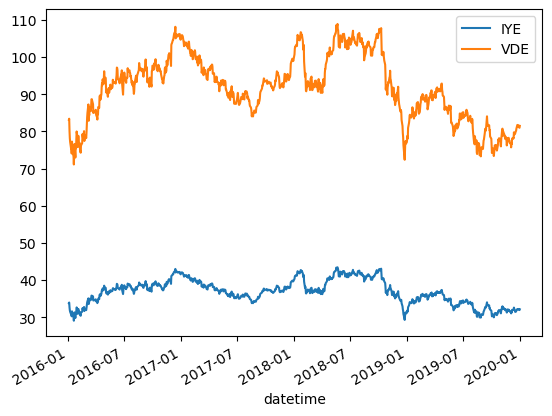

In [70]:
compose[compose.index.year > 2015].plot()

In [71]:
from sklearn.model_selection import train_test_split

train_dataset, test_dataset = train_test_split(compose.sort_index(), test_size=0.2, shuffle=False)

In [72]:
train_dataset

,IYE,VDE
datetime,,
2010-01-04,34.23,85.97
2010-01-05,34.52,86.85
2010-01-06,34.89,87.85
2010-01-07,34.75,87.64
2010-01-08,35.03,88.30
...,...,...
2017-12-21,39.38,98.23
2017-12-22,39.48,98.56
2017-12-26,39.84,99.57


In [73]:
test_dataset

,IYE,VDE
datetime,,
2017-12-29,39.65,98.95
2018-01-02,40.32,100.73
2018-01-03,40.91,102.26
2018-01-04,41.14,102.81
2018-01-05,41.11,102.78
...,...,...
2019-12-24,32.15,81.73
2019-12-26,32.20,81.67
2019-12-27,32.02,81.21


In [74]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)
tscv

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None)

In [11]:
def zscore(series):
    return (series - series.mean()) / series.std()

In [25]:
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
def get_info_fold(train_data):
    x = train_data["XLU"]
    y = train_data["XLE"]
    x = sm.add_constant(x)
    results = sm.OLS(y, x).fit()
    x = x["XLU"]
    b = results.params["XLU"]

    spread = y - x * b
    result = ts.adfuller(spread)
    print('ADF Statistic: %f' % result[0])
    
    x = spread.shift().dropna()
    y = spread - spread.shift()
    y = y.dropna()
    x = sm.add_constant(x)
    results = sm.OLS(y, x).fit()
    halflife = -math.log(2) / results.params[0]
    print('Halflife: %f' % halflife)

## RUN ALL FOLDS

In [16]:
for i, (train_index, validation_index) in enumerate(tscv.split(train_dataset)):
    train_data, validation_data = train_dataset.iloc[train_index], train_dataset.iloc[validation_index]
    print(f'--- FOLD {i} ---')
    get_info_fold(train_data)

--- FOLD 0 ---
ADF Statistic: -1.315051
Halflife: 82.551929
--- FOLD 1 ---
ADF Statistic: -2.375030
Halflife: 87.145427
--- FOLD 2 ---
ADF Statistic: -2.372884
Halflife: 118.079188
--- FOLD 3 ---
ADF Statistic: -1.792318
Halflife: 180.562308
--- FOLD 4 ---
ADF Statistic: -2.238871
Halflife: 154.170800


## RUN for each fold

In [75]:
last_fold =  list(tscv.split(train_dataset))[-1]
(train_index, validation_index) = last_fold
train_data, validation_data = train_dataset.iloc[train_index], train_dataset.iloc[validation_index]

# Augmented Dickey-Fuller (ADF) test

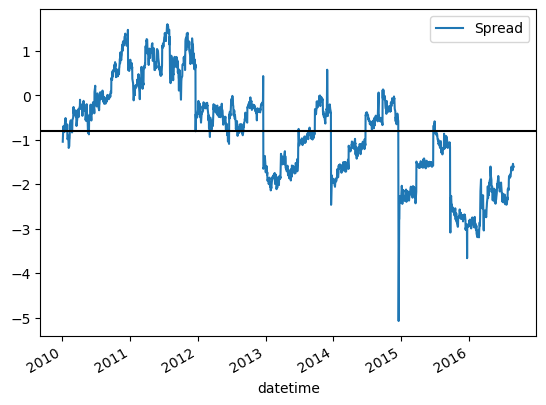

In [76]:
import statsmodels.api as sm

x = train_data["IYE"]
y = train_data["VDE"]
x = sm.add_constant(x)
results = sm.OLS(y, x).fit()
x = x["IYE"]
b = results.params["IYE"]

spread = y - x * b
spread.plot()
plt.axhline(spread.mean(), color="black")
plt.legend(["Spread"]);

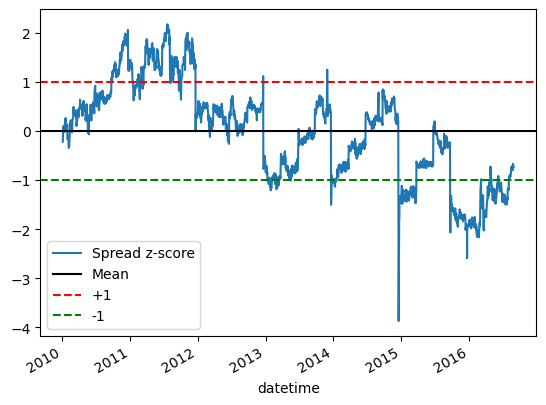

In [77]:
zscore_spread = zscore(spread)
zscore_spread.plot()
plt.axhline(zscore_spread.mean(), color="black")
plt.axhline(1.0, color="red", linestyle="--")
plt.axhline(-1.0, color="green", linestyle="--")
plt.legend(["Spread z-score", "Mean", "+1", "-1"]);

In [78]:
import statsmodels.tsa.stattools as ts

result = ts.adfuller(spread)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.218398
p-value: 0.199636
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


In [79]:
spread

datetime
2010-01-04   -1.040392
2010-01-05   -0.897553
2010-01-06   -0.838069
2010-01-07   -0.692198
2010-01-08   -0.743939
                ...   
2016-08-24   -1.681998
2016-08-25   -1.627804
2016-08-26   -1.537353
2016-08-29   -1.603675
2016-08-30   -1.606966
Length: 1677, dtype: float64

In [80]:
spread.shift().dropna()

datetime
2010-01-05   -1.040392
2010-01-06   -0.897553
2010-01-07   -0.838069
2010-01-08   -0.692198
2010-01-11   -0.743939
                ...   
2016-08-24   -1.617868
2016-08-25   -1.681998
2016-08-26   -1.627804
2016-08-29   -1.537353
2016-08-30   -1.603675
Length: 1676, dtype: float64

In [81]:
x = spread.shift().dropna()
y = spread - spread.shift()
y = y.dropna()
x = sm.add_constant(x)
results = sm.OLS(y, x).fit()

In [82]:
halflife = -math.log(2) / results.params[0]
halflife

48.23042177348128

In [83]:
price = validation_data

In [90]:
price

,IYE,VDE
datetime,,
2016-08-31,37.98,95.06
2016-09-01,37.89,94.74
2016-09-02,38.30,95.75
2016-09-06,38.86,97.25
2016-09-07,39.02,97.62
...,...,...
2017-12-21,39.38,98.23
2017-12-22,39.48,98.56
2017-12-26,39.84,99.57


In [91]:
weights = pd.DataFrame({
    "VDE": [1] * len(price),
    "IYE": [-b] * len(price)
}, index=price.index)
weights

,VDE,IYE
datetime,,
2016-08-31,1,-2.541934
2016-09-01,1,-2.541934
2016-09-02,1,-2.541934
2016-09-06,1,-2.541934
2016-09-07,1,-2.541934
...,...,...
2017-12-21,1,-2.541934
2017-12-22,1,-2.541934
2017-12-26,1,-2.541934


In [92]:
spread = (price * weights).sum(axis=1)
spread

datetime
2016-08-31   -1.482644
2016-09-01   -1.573870
2016-09-02   -1.606063
2016-09-06   -1.529546
2016-09-07   -1.566255
                ...   
2017-12-21   -1.871351
2017-12-22   -1.795545
2017-12-26   -1.700641
2017-12-27   -1.633093
2017-12-28   -1.706447
Length: 335, dtype: float64

In [93]:
lookback = round(halflife)
lookback

48

In [94]:
num_units = -(spread - spread.rolling(lookback).mean()) / (spread.rolling(lookback).std())
num_units

datetime
2016-08-31         NaN
2016-09-01         NaN
2016-09-02         NaN
2016-09-06         NaN
2016-09-07         NaN
                ...   
2017-12-21    0.779370
2017-12-22    0.296956
2017-12-26   -0.291396
2017-12-27   -0.687055
2017-12-28   -0.234379
Length: 335, dtype: float64

In [95]:
num_units.describe()

count    288.000000
mean       0.322678
std        1.211852
min       -6.123270
25%       -0.360376
50%        0.251499
75%        0.944770
max        5.166459
dtype: float64

<Axes: xlabel='datetime'>

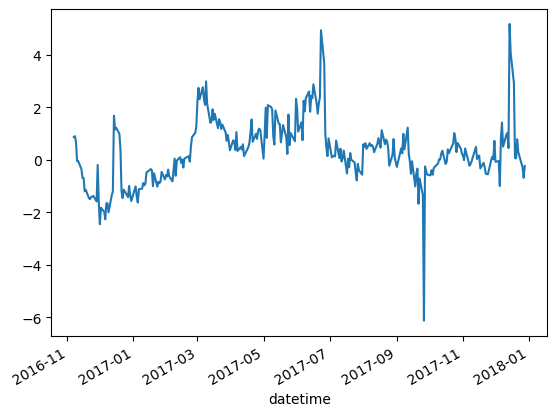

In [96]:
num_units.plot()

In [97]:
positions = weights.mul(num_units, axis=0) * price
positions

,IYE,VDE
datetime,,
2016-08-31,NaN,NaN
2016-09-01,NaN,NaN
2016-09-02,NaN,NaN
2016-09-06,NaN,NaN
2016-09-07,NaN,NaN
...,...,...
2017-12-21,-78.015959,76.557485
2017-12-22,-29.801141,29.267944
2017-12-26,29.509890,-29.014329


<Axes: xlabel='datetime'>

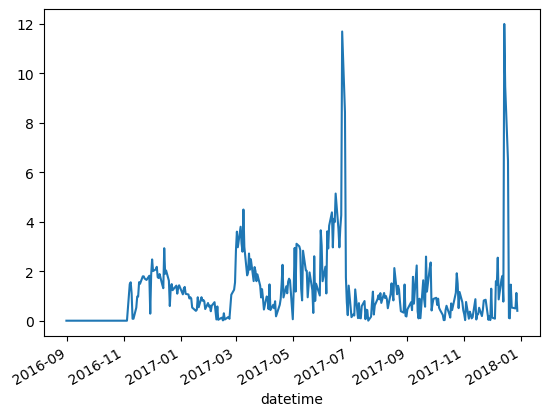

In [98]:
positions.sum(axis=1).abs().plot()

In [99]:
pnl = positions.shift(1) * (price - price.shift(1)) / price.shift(1)
pnl = pnl.sum(axis=1)

In [100]:
pnl.describe()

count    335.000000
mean       0.038308
std        0.460985
min       -1.610227
25%       -0.014411
50%        0.000000
75%        0.033128
max        7.644209
dtype: float64

In [101]:
ret = pnl / positions.shift(1).sum(axis=1).abs()
ret

datetime
2016-08-31         NaN
2016-09-01         NaN
2016-09-02         NaN
2016-09-06         NaN
2016-09-07         NaN
                ...   
2017-12-21   -0.068911
2017-12-22    0.040509
2017-12-26    0.052855
2017-12-27   -0.039719
2017-12-28    0.044918
Length: 335, dtype: float64

In [102]:
ret.describe()

count    287.000000
mean       0.015642
std        0.210526
min       -0.757605
25%       -0.030722
50%        0.006327
75%        0.039554
max        3.246641
dtype: float64

<Axes: xlabel='datetime'>

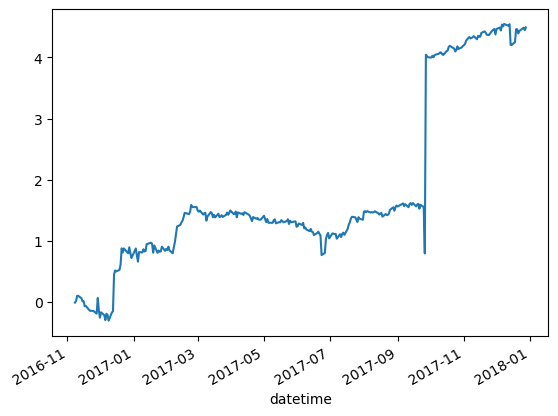

In [103]:
ret.cumsum().plot()

In [104]:
sharp_ratio = math.sqrt(252)*ret.mean()/ret.std()
sharp_ratio

1.1794507411050186

In [105]:
term = pd.DataFrame({
    "ret": ret.cumsum().dropna(),
    'lagged_ret': ret.cumsum().dropna().shift(1),
    'high_watermark_index': ret.cumsum().dropna().index
})
term['lagged_ret'] = term['lagged_ret'].fillna(0)
term

,ret,lagged_ret,high_watermark_index
datetime,,,
2016-11-08,-0.007769,0.000000,2016-11-08
2016-11-09,0.017855,-0.007769,2016-11-09
2016-11-10,0.102520,0.017855,2016-11-10
2016-11-11,0.102688,0.102520,2016-11-11
2016-11-14,0.062272,0.102688,2016-11-14
...,...,...,...
2017-12-21,4.390609,4.459521,2017-12-21
2017-12-22,4.431118,4.390609,2017-12-22
2017-12-26,4.483973,4.431118,2017-12-26


In [106]:
highest_watermark_index = term.iloc[0]['high_watermark_index']
for d in term.index:
    row = term.loc[d]
    if row['ret'] >= term.loc[highest_watermark_index]['ret']:
        highest_watermark_index = d
    term.loc[d, 'high_watermark_index']= highest_watermark_index

In [107]:
term

,ret,lagged_ret,high_watermark_index
datetime,,,
2016-11-08,-0.007769,0.000000,2016-11-08
2016-11-09,0.017855,-0.007769,2016-11-09
2016-11-10,0.102520,0.017855,2016-11-10
2016-11-11,0.102688,0.102520,2016-11-11
2016-11-14,0.062272,0.102688,2016-11-11
...,...,...,...
2017-12-21,4.390609,4.459521,2017-12-08
2017-12-22,4.431118,4.390609,2017-12-08
2017-12-26,4.483973,4.431118,2017-12-08


In [108]:
term['high_watermark_ret'] = term.apply(lambda x: term.loc[x['high_watermark_index']]['ret'], axis=1)
term['drawdown_deep'] = term['high_watermark_ret'] - term['ret']
term['drawdown_duration'] = term.index - term['high_watermark_index']
term

,ret,lagged_ret,high_watermark_index,high_watermark_ret,drawdown_deep,drawdown_duration
datetime,,,,,,
2016-11-08,-0.007769,0.000000,2016-11-08,-0.007769,0.000000,0 days
2016-11-09,0.017855,-0.007769,2016-11-09,0.017855,0.000000,0 days
2016-11-10,0.102520,0.017855,2016-11-10,0.102520,0.000000,0 days
2016-11-11,0.102688,0.102520,2016-11-11,0.102688,0.000000,0 days
2016-11-14,0.062272,0.102688,2016-11-11,0.102688,0.040416,3 days
...,...,...,...,...,...,...
2017-12-21,4.390609,4.459521,2017-12-08,4.545509,0.154900,13 days
2017-12-22,4.431118,4.390609,2017-12-08,4.545509,0.114391,14 days
2017-12-26,4.483973,4.431118,2017-12-08,4.545509,0.061536,18 days


In [109]:
term.describe()

,ret,lagged_ret,high_watermark_index,high_watermark_ret,drawdown_deep,drawdown_duration
count,287.000000,287.000000,287,287.000000,287.000000,287
mean,1.820336,1.804694,2017-04-17 15:03:08.153310208,1.976447,0.156111,47 days 22:09:37.003484320
min,-0.303423,-0.303423,2016-11-08 00:00:00,-0.007769,0.000000,0 days 00:00:00
25%,1.095630,1.092610,2017-02-22 12:00:00,1.533069,0.023420,2 days 00:00:00
50%,1.390061,1.389257,2017-02-23 00:00:00,1.588800,0.119595,15 days 00:00:00
75%,1.597829,1.592794,2017-09-15 00:00:00,1.618922,0.242906,88 days 12:00:00
max,4.545509,4.545509,2017-12-08 00:00:00,4.545509,0.822542,190 days 00:00:00
std,1.404596,1.399759,NaN,1.347474,0.157428,59 days 01:55:18.757796868


In [110]:
term['drawdown_deep'].idxmax()

Timestamp('2017-09-26 00:00:00')

In [115]:
term.loc[term['drawdown_deep'].idxmax()]

ret                                0.796379
lagged_ret                         1.553985
high_watermark_index    2017-09-15 00:00:00
high_watermark_ret                 1.618922
drawdown_deep                      0.822542
drawdown_duration          11 days 00:00:00
Name: 2017-09-26 00:00:00, dtype: object

In [111]:
term['drawdown_duration'].idxmax()

Timestamp('2017-09-01 00:00:00')

<Axes: xlabel='datetime'>

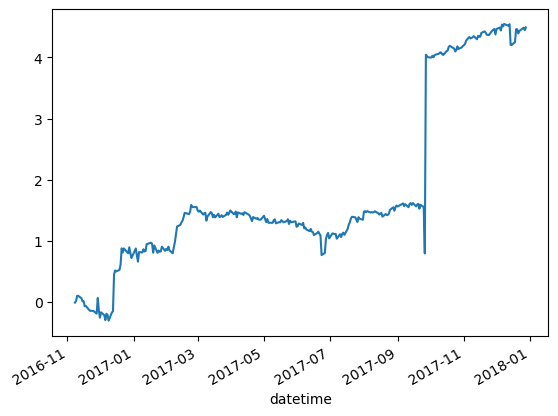

In [112]:
term['ret'].plot()

# Johansen Cointegration Test

In [116]:
train_data

,IYE,VDE
datetime,,
2010-01-04,34.23,85.97
2010-01-05,34.52,86.85
2010-01-06,34.89,87.85
2010-01-07,34.75,87.64
2010-01-08,35.03,88.30
...,...,...
2016-08-24,38.68,96.64
2016-08-25,38.58,96.44
2016-08-26,38.45,96.20


In [117]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

# x is a dataframe of n series for cointegration analysis
jres = coint_johansen(train_data, det_order=0, k_ar_diff=1)
print(f'Eigen statistic: \n\t{jres.max_eig_stat}')
print(f'Eigen statistic critical: \n\t{jres.max_eig_stat_crit_vals}')
print(f'Eigen vector: \n\t{jres.evec.T}')
print(f'Eigen value: \n\t{jres.eig}')

Eigen statistic: 
	[8.84155046 3.75160615]
Eigen statistic critical: 
	[[12.2971 14.2639 18.52  ]
 [ 2.7055  3.8415  6.6349]]
Eigen vector: 
	[[ 2.30766623 -0.91014639]
 [-0.2426138   0.03376747]]
Eigen value: 
	[0.00526463 0.00223726]


In [118]:
w1, w2 = jres.evec.T
print(w1 / w1[0])
print(w2 / w2[0])

[ 1.         -0.39440123]
[ 1.         -0.13918199]


In [119]:
price = train_data

In [137]:
a, b = w2
weights = pd.DataFrame({
    "IYE": [a] * len(price),
    "VDE": [b] * len(price)
}, index=price.index)
weights

,IYE,VDE
datetime,,
2016-08-31,-0.242614,0.033767
2016-09-01,-0.242614,0.033767
2016-09-02,-0.242614,0.033767
2016-09-06,-0.242614,0.033767
2016-09-07,-0.242614,0.033767
...,...,...
2017-12-21,-0.242614,0.033767
2017-12-22,-0.242614,0.033767
2017-12-26,-0.242614,0.033767


In [138]:
spread = (weights * price).sum(axis=1)
spread

datetime
2016-08-31   -6.004536
2016-09-01   -5.993507
2016-09-02   -6.058873
2016-09-06   -6.144086
2016-09-07   -6.170410
                ...   
2017-12-21   -6.237153
2017-12-22   -6.250271
2017-12-26   -6.303507
2017-12-27   -6.273005
2017-12-28   -6.288025
Length: 335, dtype: float64

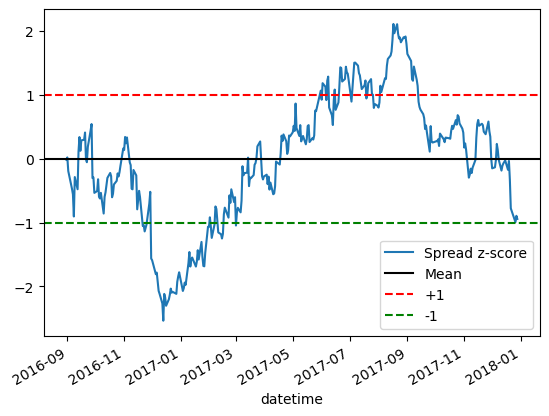

In [139]:
zscore_spread = zscore(spread)
zscore_spread.plot()
plt.axhline(zscore_spread.mean(), color="black")
plt.axhline(1.0, color="red", linestyle="--")
plt.axhline(-1.0, color="green", linestyle="--")
plt.legend(["Spread z-score", "Mean", "+1", "-1"]);

In [140]:
x = spread.shift().dropna()
y = spread - spread.shift()
y = y.dropna()
x = sm.add_constant(x)
results = sm.OLS(y, x).fit()
halflife = -math.log(2) / results.params[0]
print('Halflife: %f' % halflife)

Halflife: 37.038300


In [141]:
price = validation_data
price

,IYE,VDE
datetime,,
2016-08-31,37.98,95.06
2016-09-01,37.89,94.74
2016-09-02,38.30,95.75
2016-09-06,38.86,97.25
2016-09-07,39.02,97.62
...,...,...
2017-12-21,39.38,98.23
2017-12-22,39.48,98.56
2017-12-26,39.84,99.57


In [143]:
a, b = w2
weights = pd.DataFrame({
    "IYE": [a] * len(price),
    "VDE": [b] * len(price)
}, index=price.index)
weights

,IYE,VDE
datetime,,
2016-08-31,-0.242614,0.033767
2016-09-01,-0.242614,0.033767
2016-09-02,-0.242614,0.033767
2016-09-06,-0.242614,0.033767
2016-09-07,-0.242614,0.033767
...,...,...
2017-12-21,-0.242614,0.033767
2017-12-22,-0.242614,0.033767
2017-12-26,-0.242614,0.033767


In [144]:
spread = weights * price

In [145]:
lookback = round(halflife)
lookback

37

In [146]:
num_units = -(spread - spread.rolling(lookback).mean()) / (spread.rolling(lookback).std())
num_units

,IYE,VDE
datetime,,
2016-08-31,NaN,NaN
2016-09-01,NaN,NaN
2016-09-02,NaN,NaN
2016-09-06,NaN,NaN
2016-09-07,NaN,NaN
...,...,...
2017-12-21,2.715243,-2.698803
2017-12-22,2.541473,-2.569641
2017-12-26,2.670177,-2.737690


In [147]:
positions = weights.mul(num_units, axis=0) * price
positions

,IYE,VDE
datetime,,
2016-08-31,NaN,NaN
2016-09-01,NaN,NaN
2016-09-02,NaN,NaN
2016-09-06,NaN,NaN
2016-09-07,NaN,NaN
...,...,...
2017-12-21,-25.941791,-8.951871
2017-12-22,-24.343227,-8.552079
2017-12-26,-25.809224,-9.204735


In [148]:
positions.dropna()

,IYE,VDE
datetime,,
2016-10-21,-4.635355,-1.854969
2016-10-24,-2.926940,-1.217201
2016-10-25,0.334236,0.017568
2016-10-26,-0.596388,-0.182037
2016-10-27,0.845281,0.286502
...,...,...
2017-12-21,-25.941791,-8.951871
2017-12-22,-24.343227,-8.552079
2017-12-26,-25.809224,-9.204735


In [149]:
pnl = positions.shift(1) * (price - price.shift(1)) / price.shift(1)
pnl.describe()

,IYE,VDE
count,298.000000,298.000000
mean,0.001259,0.000085
std,0.113510,0.040167
min,-0.325924,-0.122583
25%,-0.049024,-0.018053
50%,0.000000,0.000078
75%,0.041999,0.013917
max,0.497348,0.218071


In [150]:
ret = pnl.sum(axis=1) / positions.shift(1).sum(axis=1).abs()
ret

datetime
2016-08-31         NaN
2016-09-01         NaN
2016-09-02         NaN
2016-09-06         NaN
2016-09-07         NaN
                ...   
2017-12-21   -0.021838
2017-12-22   -0.002750
2017-12-26   -0.009412
2017-12-27    0.004360
2017-12-28   -0.001830
Length: 335, dtype: float64

In [151]:
ret.dropna().describe()

count    298.000000
mean      -0.000076
std        0.009700
min       -0.054823
25%       -0.004881
50%        0.000164
75%        0.005754
max        0.026220
dtype: float64

<Axes: xlabel='datetime'>

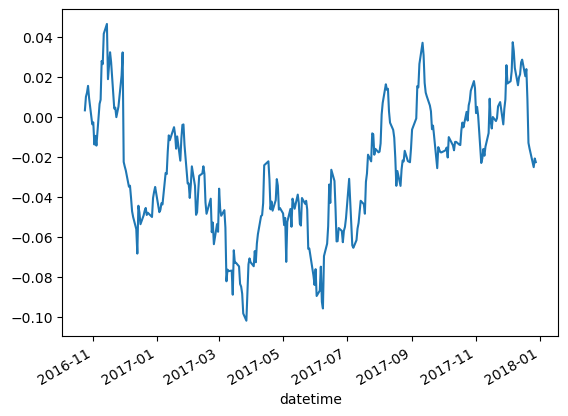

In [152]:
ret.cumsum().plot()

In [153]:
sharp_ratio = math.sqrt(252)*ret.mean()/ret.std()
sharp_ratio

-0.12454150029412656

In [154]:
term = pd.DataFrame({
    "ret": ret.cumsum().dropna(),
    'lagged_ret': ret.cumsum().dropna().shift(1),
    'high_watermark_index': ret.cumsum().dropna().index
})
term['lagged_ret'] = term['lagged_ret'].fillna(0)
term

,ret,lagged_ret,high_watermark_index
datetime,,,
2016-10-24,0.003239,0.000000,2016-10-24
2016-10-25,0.010051,0.003239,2016-10-25
2016-10-26,0.012103,0.010051,2016-10-26
2016-10-27,0.015493,0.012103,2016-10-27
2016-10-28,0.009388,0.015493,2016-10-28
...,...,...,...
2017-12-21,-0.013046,0.008792,2017-12-21
2017-12-22,-0.015796,-0.013046,2017-12-22
2017-12-26,-0.025208,-0.015796,2017-12-26


In [155]:
highest_watermark_index = term.iloc[0]['high_watermark_index']
for d in term.index:
    row = term.loc[d]
    if row['ret'] >= term.loc[highest_watermark_index]['ret']:
        highest_watermark_index = d
    term.loc[d, 'high_watermark_index']= highest_watermark_index
term

,ret,lagged_ret,high_watermark_index
datetime,,,
2016-10-24,0.003239,0.000000,2016-10-24
2016-10-25,0.010051,0.003239,2016-10-25
2016-10-26,0.012103,0.010051,2016-10-26
2016-10-27,0.015493,0.012103,2016-10-27
2016-10-28,0.009388,0.015493,2016-10-27
...,...,...,...
2017-12-21,-0.013046,0.008792,2016-11-14
2017-12-22,-0.015796,-0.013046,2016-11-14
2017-12-26,-0.025208,-0.015796,2016-11-14


In [156]:
term['high_watermark_ret'] = term.apply(lambda x: term.loc[x['high_watermark_index']]['ret'], axis=1)
term['drawdown_deep'] = term['high_watermark_ret'] - term['ret']
term['drawdown_duration'] = term.index - term['high_watermark_index']
term

,ret,lagged_ret,high_watermark_index,high_watermark_ret,drawdown_deep,drawdown_duration
datetime,,,,,,
2016-10-24,0.003239,0.000000,2016-10-24,0.003239,0.000000,0 days
2016-10-25,0.010051,0.003239,2016-10-25,0.010051,0.000000,0 days
2016-10-26,0.012103,0.010051,2016-10-26,0.012103,0.000000,0 days
2016-10-27,0.015493,0.012103,2016-10-27,0.015493,0.000000,0 days
2016-10-28,0.009388,0.015493,2016-10-27,0.015493,0.006105,1 days
...,...,...,...,...,...,...
2017-12-21,-0.013046,0.008792,2016-11-14,0.046483,0.059529,402 days
2017-12-22,-0.015796,-0.013046,2016-11-14,0.046483,0.062279,403 days
2017-12-26,-0.025208,-0.015796,2016-11-14,0.046483,0.071691,407 days


In [157]:
term.describe()

,ret,lagged_ret,high_watermark_index,high_watermark_ret,drawdown_deep,drawdown_duration
count,298.000000,298.000000,298,298.000000,298.000000,298
mean,-0.026459,-0.026383,2016-11-13 05:04:25.771812096,0.045024,0.071483,195 days 07:39:03.624161074
min,-0.102067,-0.102067,2016-10-24 00:00:00,0.003239,0.000000,0 days 00:00:00
25%,-0.048541,-0.048541,2016-11-14 00:00:00,0.046483,0.048421,87 days 06:00:00
50%,-0.024837,-0.024837,2016-11-14 00:00:00,0.046483,0.071321,195 days 00:00:00
75%,-0.003130,-0.002882,2016-11-14 00:00:00,0.046483,0.095024,302 days 18:00:00
max,0.046483,0.046483,2016-11-14 00:00:00,0.046483,0.148550,409 days 00:00:00
std,0.031432,0.031469,NaN,0.006641,0.033511,123 days 11:56:00.279695278


# Bollinger Band

In [158]:
price = validation_data
price

,IYE,VDE
datetime,,
2016-08-31,37.98,95.06
2016-09-01,37.89,94.74
2016-09-02,38.30,95.75
2016-09-06,38.86,97.25
2016-09-07,39.02,97.62
...,...,...
2017-12-21,39.38,98.23
2017-12-22,39.48,98.56
2017-12-26,39.84,99.57


In [159]:
a, b = w2
weights = pd.DataFrame({
    "IYE": [a] * len(price),
    "VDE": [b] * len(price)
}, index=price.index)
weights

,IYE,VDE
datetime,,
2016-08-31,-0.242614,0.033767
2016-09-01,-0.242614,0.033767
2016-09-02,-0.242614,0.033767
2016-09-06,-0.242614,0.033767
2016-09-07,-0.242614,0.033767
...,...,...
2017-12-21,-0.242614,0.033767
2017-12-22,-0.242614,0.033767
2017-12-26,-0.242614,0.033767


In [160]:
entry_zscore = 1.5
exit_zscore = 0

In [161]:
spread = (weights * price).sum(axis=1)
spread

datetime
2016-08-31   -6.004536
2016-09-01   -5.993507
2016-09-02   -6.058873
2016-09-06   -6.144086
2016-09-07   -6.170410
                ...   
2017-12-21   -6.237153
2017-12-22   -6.250271
2017-12-26   -6.303507
2017-12-27   -6.273005
2017-12-28   -6.288025
Length: 335, dtype: float64

In [162]:
zscore_spread = (spread - spread.rolling(lookback).mean()) / spread.rolling(lookback).std()
zscore_spread.describe()

count    299.000000
mean       0.173219
std        1.344341
min       -3.365865
25%       -0.917563
50%        0.374347
75%        1.301651
max        2.907646
dtype: float64

In [163]:
zscore_spread

datetime
2016-08-31         NaN
2016-09-01         NaN
2016-09-02         NaN
2016-09-06         NaN
2016-09-07         NaN
                ...   
2017-12-21   -2.709474
2017-12-22   -2.515326
2017-12-26   -2.624541
2017-12-27   -2.143080
2017-12-28   -2.057667
Length: 335, dtype: float64

In [164]:
long_entry = zscore_spread < -entry_zscore
long_exit = zscore_spread >= exit_zscore
short_entry = zscore_spread > entry_zscore
short_exit = zscore_spread <= exit_zscore

In [165]:
num_unit_longs = pd.Series(np.NaN, index=zscore_spread.index)
num_unit_shorts = pd.Series(np.NaN, index=zscore_spread.index)

<Axes: xlabel='datetime'>

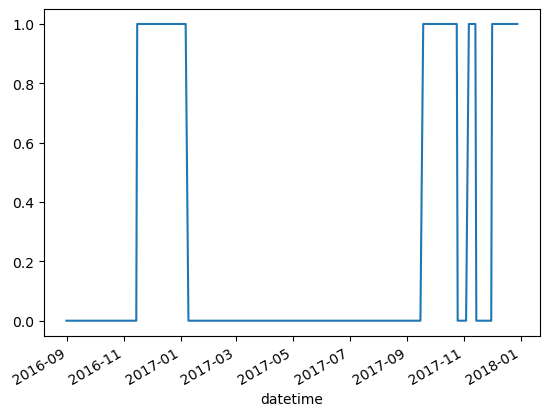

In [166]:
num_unit_longs.iloc[0] = 0
num_unit_longs[long_entry] = 1
num_unit_longs[long_exit] = 0
num_unit_longs = num_unit_longs.fillna(method='ffill')
num_unit_longs.plot()

<Axes: xlabel='datetime'>

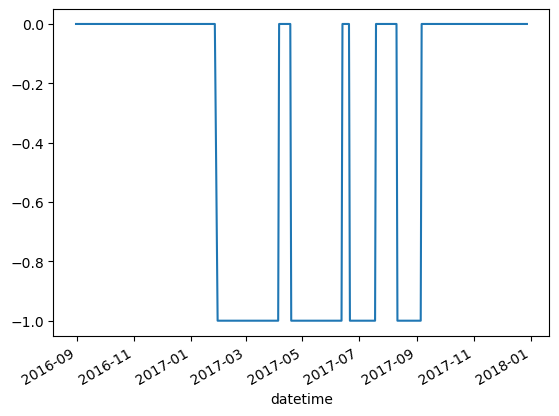

In [167]:
num_unit_shorts.iloc[0] = 0
num_unit_shorts[short_entry] = -1
num_unit_shorts[short_exit] = 0
num_unit_shorts = num_unit_shorts.fillna(method='ffill')
num_unit_shorts.plot()

<Axes: xlabel='datetime'>

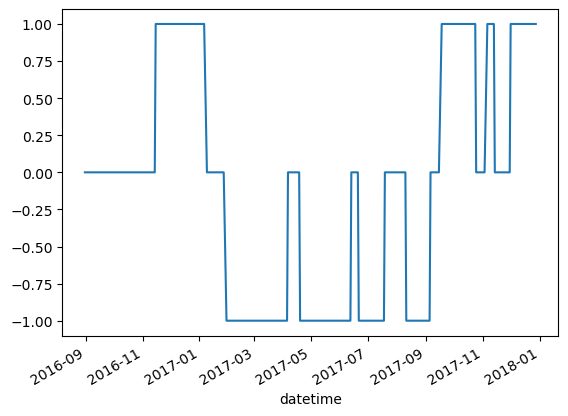

In [168]:
num_unit = num_unit_longs + num_unit_shorts
num_unit.plot()

In [169]:
positions = weights.mul(num_unit, axis=0) * price
positions

,IYE,VDE
datetime,,
2016-08-31,-0.000000,0.000000
2016-09-01,-0.000000,0.000000
2016-09-02,-0.000000,0.000000
2016-09-06,-0.000000,0.000000
2016-09-07,-0.000000,0.000000
...,...,...
2017-12-21,-9.554131,3.316979
2017-12-22,-9.578393,3.328122
2017-12-26,-9.665734,3.362227


<Axes: xlabel='datetime'>

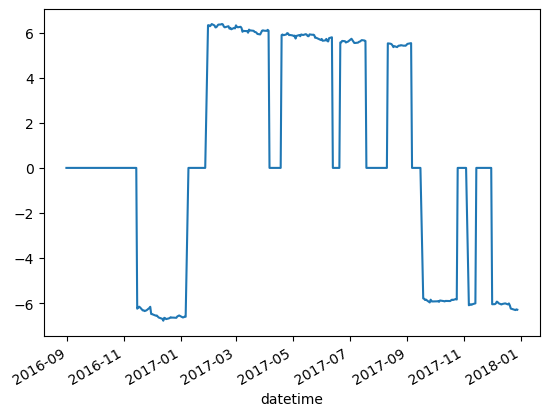

In [170]:
positions.sum(axis=1).plot()

<Axes: xlabel='datetime'>

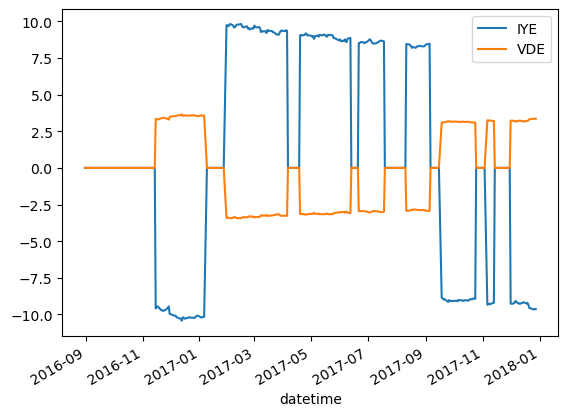

In [171]:
positions.plot()

In [172]:
pnl = positions.shift(1) * (price - price.shift(1))/price.shift(1)
pnl = pnl.sum(axis=1)
pnl.describe()

count    335.000000
mean      -0.000886
std        0.045646
min       -0.319378
25%       -0.013962
50%        0.000000
75%        0.010936
max        0.147628
dtype: float64

<Axes: xlabel='datetime'>

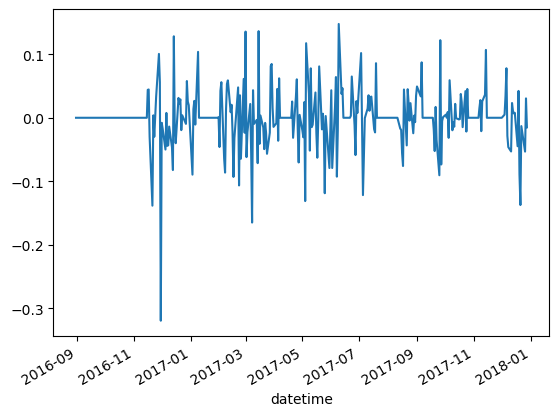

In [173]:
pnl.plot()

In [174]:
ret = pnl / positions.shift(1).sum(axis=1)
ret

datetime
2016-08-31         NaN
2016-09-01         NaN
2016-09-02         NaN
2016-09-06         NaN
2016-09-07         NaN
                ...   
2017-12-21    0.022515
2017-12-22    0.002103
2017-12-26    0.008517
2017-12-27   -0.004839
2017-12-28    0.002394
Length: 335, dtype: float64

In [175]:
ret.describe()

count    208.000000
mean       0.000312
std        0.009628
min       -0.026598
25%       -0.004501
50%       -0.000053
75%        0.005956
max        0.051862
dtype: float64

<Axes: xlabel='datetime'>

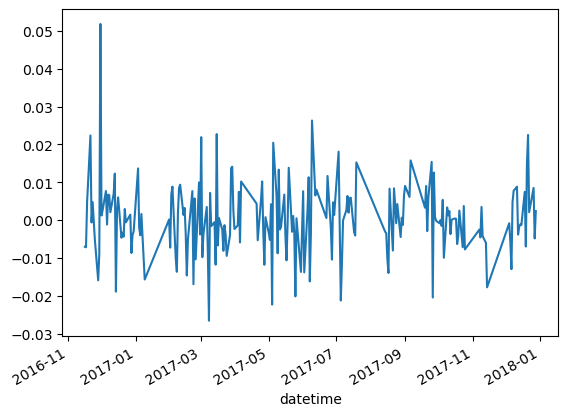

In [176]:
ret.dropna().plot()

<Axes: xlabel='datetime'>

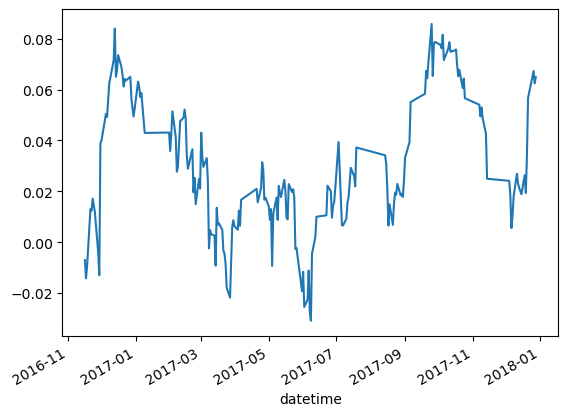

In [177]:
ret.cumsum().dropna().plot()

In [178]:
sharp_ratio = math.sqrt(252)*ret.mean()/ret.std()
sharp_ratio

0.5143436707205999

In [179]:
term = pd.DataFrame({
    "ret": ret.cumsum().dropna(),
    'lagged_ret': ret.cumsum().dropna().shift(1),
    'high_watermark_index': ret.cumsum().dropna().index
})
term['lagged_ret'] = term['lagged_ret'].fillna(0)
term

,ret,lagged_ret,high_watermark_index
datetime,,,
2016-11-16,-0.007042,0.000000,2016-11-16
2016-11-17,-0.014223,-0.007042,2016-11-17
2016-11-18,-0.009366,-0.014223,2016-11-18
2016-11-21,0.013004,-0.009366,2016-11-21
2016-11-22,0.012397,0.013004,2016-11-22
...,...,...,...
2017-12-21,0.056707,0.034192,2017-12-21
2017-12-22,0.058810,0.056707,2017-12-22
2017-12-26,0.067327,0.058810,2017-12-26


In [180]:
highest_watermark_index = term.iloc[0]['high_watermark_index']
for d in term.index:
    row = term.loc[d]
    if row['ret'] >= term.loc[highest_watermark_index]['ret']:
        highest_watermark_index = d
    term.loc[d, 'high_watermark_index']= highest_watermark_index
term

,ret,lagged_ret,high_watermark_index
datetime,,,
2016-11-16,-0.007042,0.000000,2016-11-16
2016-11-17,-0.014223,-0.007042,2016-11-16
2016-11-18,-0.009366,-0.014223,2016-11-16
2016-11-21,0.013004,-0.009366,2016-11-21
2016-11-22,0.012397,0.013004,2016-11-21
...,...,...,...
2017-12-21,0.056707,0.034192,2017-09-25
2017-12-22,0.058810,0.056707,2017-09-25
2017-12-26,0.067327,0.058810,2017-09-25


In [181]:
term['high_watermark_ret'] = term.apply(lambda x: term.loc[x['high_watermark_index']]['ret'], axis=1)
term['drawdown_deep'] = term['high_watermark_ret'] - term['ret']
term['drawdown_duration'] = term.index - term['high_watermark_index']
term

,ret,lagged_ret,high_watermark_index,high_watermark_ret,drawdown_deep,drawdown_duration
datetime,,,,,,
2016-11-16,-0.007042,0.000000,2016-11-16,-0.007042,0.000000,0 days
2016-11-17,-0.014223,-0.007042,2016-11-16,-0.007042,0.007181,1 days
2016-11-18,-0.009366,-0.014223,2016-11-16,-0.007042,0.002324,2 days
2016-11-21,0.013004,-0.009366,2016-11-21,0.013004,0.000000,0 days
2016-11-22,0.012397,0.013004,2016-11-21,0.013004,0.000607,1 days
...,...,...,...,...,...,...
2017-12-21,0.056707,0.034192,2017-09-25,0.085808,0.029102,87 days
2017-12-22,0.058810,0.056707,2017-09-25,0.085808,0.026998,88 days
2017-12-26,0.067327,0.058810,2017-09-25,0.085808,0.018481,92 days


In [182]:
term.describe()

,ret,lagged_ret,high_watermark_index,high_watermark_ret,drawdown_deep,drawdown_duration
count,208.000000,208.000000,208,208.000000,208.000000,208
mean,0.030394,0.030082,2017-02-14 07:30:00,0.079757,0.049364,102 days 19:43:50.769230769
min,-0.030895,-0.030895,2016-11-16 00:00:00,-0.007042,0.000000,0 days 00:00:00
25%,0.011718,0.010971,2016-12-13 00:00:00,0.083956,0.021366,23 days 18:00:00
50%,0.023715,0.023186,2016-12-13 00:00:00,0.083956,0.058285,86 days 00:00:00
75%,0.054323,0.053248,2016-12-13 00:00:00,0.083956,0.069242,163 days 06:00:00
max,0.085808,0.085808,2017-09-25 00:00:00,0.085808,0.114851,283 days 00:00:00
std,0.027333,0.027308,NaN,0.016874,0.029327,82 days 15:22:54.061114340
